In [52]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import tqdm
import warnings
warnings.filterwarnings('ignore')

In [35]:
#get trend objects with thailand offset 7*60 = 420 minutes
trend = TrendReq(hl='th-TH', tz=420)

In [66]:
#compare 2 keywords
kw_list = ['itaewon class', 'โคชูจัง']
trend.build_payload(kw_list, geo='TH',timeframe='2020-01-01 2020-04-30')
df = trend.interest_over_time()
df.head()

,itaewon class,โคชูจัง,isPartial
date,,,
2020-01-01,0,2,False
2020-01-02,0,1,False
2020-01-03,0,1,False
2020-01-04,0,3,False
2020-01-05,0,3,False


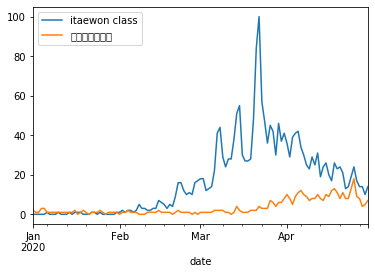

In [67]:
df.iloc[:,:2].plot()